# LabAst577 - Observational Astronomy
# Notebook with some basic data reduction and analysis with python 

## First, import necessary libraries

In [3]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from astropy.io import fits

## Let's open fits files

In [5]:
dir = '/Volumes/VselenaNovo/surveys/CIGEO/20191025/' # directory where fits files are found
file1,file2 = dir+'flat_2019-10-25_17-59-11_Blue_0024.fits',dir+'flat_2019-10-25_17-59-19_Blue_0025.fits' #file names
head1,head2 = fits.getheader(file1),fits.getheader(file2) # header information
flat1,flat2 = fits.getdata(file1),fits.getdata(file2)  # data matrices

## Plot fits files

Text(0,0.5,'ypix')

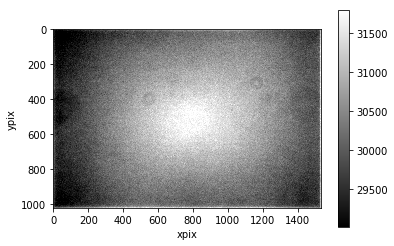

In [50]:
#one plot
lo,up = np.percentile(flat1,1),np.percentile(flat1,99)
plt.figure()
plt.imshow(flat1,cmap='gray',clim=(lo,up))
plt.colorbar()
plt.xlabel('xpix')
plt.ylabel('ypix')

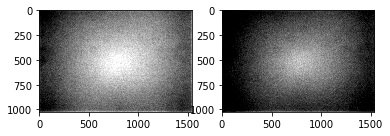

In [24]:
#two plots
fig,ax = plt.subplots(1,2)
ax[0].imshow(flat1,cmap='gray',clim=(lo,up))
ax[1].imshow(flat2,cmap='gray',clim=(lo,up))

## Stack two images

In [25]:
allflat = np.asarray([flat1,flat2])
medianflat,meanflat,sumflat = np.median(allflat,axis=0),np.mean(allflat,axis=0),np.sum(allflat,axis=0)

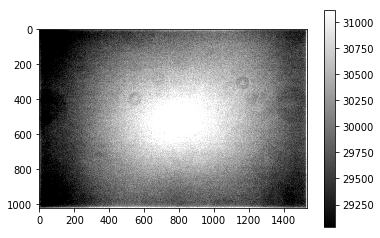

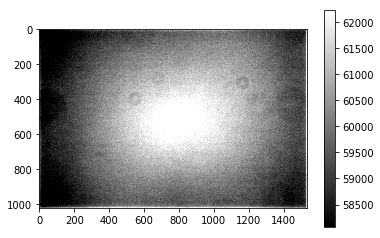

In [29]:
#plot them
lo,up = np.percentile(medianflat,5),np.percentile(medianflat,95)
plt.figure()
plt.imshow(medianflat,cmap='gray',clim=(lo,up))
plt.colorbar()
lo,up = np.percentile(sumflat,5),np.percentile(sumflat,95)
plt.figure()
plt.imshow(sumflat,cmap='gray',clim=(lo,up))
plt.colorbar()

## Shift image to align with another

In [30]:
#First load two other images: 
data1 = fits.getdata(dir+'hip93124_2019-10-25_19-12-11_Green_0187.fits')
data2 = fits.getdata(dir+'hip93124_2019-10-25_19-19-44_Green_0220.fits')
head2 = fits.getheader(dir+'hip93124_2019-10-25_19-19-44_Green_0220.fits')

In [31]:
## Obtain rough position with the mouse
pos1 = [818,615]
pos2 = [841,621]

(array([819.47690637, 614.53114138]), array([841.5423289, 619.2479296]))
(array([818.53312505, 614.68637751]), array([840.70160141, 620.09677289]))


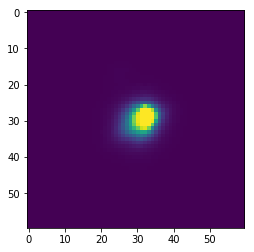

In [32]:
## Get centroid
from photutils import centroid_com, centroid_2dg  #load centroid libraries
subdata1 = data1[pos1[1]-30:pos1[1]+30,pos1[0]-30:pos1[0]+30]#select subportion of 60x60 image
subdata2 = data2[pos2[1]-30:pos2[1]+30,pos2[0]-30:pos2[0]+30]#select subportion of 60x60 image
plt.imshow(subdata1)
center1,center2 = centroid_2dg(subdata1)+pos1-[30,30],centroid_2dg(subdata2)+pos2-[30,30]
ccenter1,ccenter2 = centroid_com(subdata1)+pos1-[30,30],centroid_com(subdata2)+pos2-[30,30]
print(center1,center2)
print(ccenter1,ccenter2)

In [33]:
## Shift image
shiftdat = np.roll(data2,-np.int(np.round(center2[1]-center1[1])),axis=0) #shift in y
shiftdata2 = np.roll(shiftdat,-np.int(np.round(center2[0]-center1[0])),axis=1) #shift in x

In [36]:
## Save image
head2['PROCESS'] = 'shifted'
fits.writeto(dir+'hip93124_2019-10-25_19-19-44_Green_0220_shifted.fits',shiftdata2,head2,overwrite=True)

## Get background and background noise

In [37]:
#Load an image
image = fits.getdata(dir+'ngc6946_2019-10-25_20-23-17_black_0327.fits')

In [38]:
from photutils import Background2D,MedianBackground
from astropy.stats import SigmaClip
sigma_clip = SigmaClip(sigma=3.0) 
bkg_estimator = MedianBackground()
bkg = Background2D(image,(50,50),filter_size=(3,3),sigma_clip=sigma_clip,
                   bkg_estimator=bkg_estimator)
print("      Median background found: %f, median bkg noise: %f"
      %(bkg.background_median,bkg.background_rms_median)  )

      Median background found: 1369.000000, median bkg noise: 20.977891


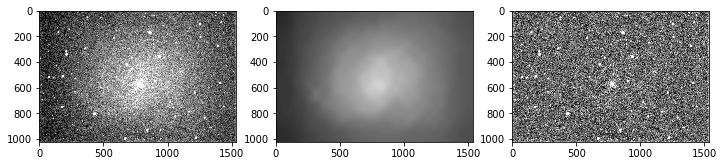

In [51]:
fig,ax = plt.subplots(1,3,figsize=(12,6))
lo,up = np.percentile(image,1),np.percentile(image,99)
ax[0].imshow(image,cmap='gray',clim=(lo,up))
ax[1].imshow(bkg.background,cmap='gray',clim=(lo,up))
lo,up = np.percentile(image-bkg.background,1),np.percentile(image-bkg.background,99)
ax[2].imshow(image-bkg.background,cmap='gray',clim=(lo,up))

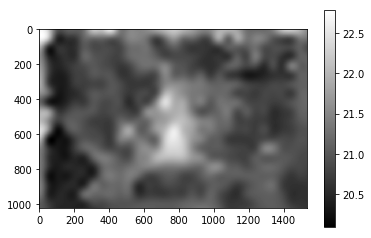

In [41]:
plt.imshow(bkg.background_rms,cmap='gray')
plt.colorbar()

## Get astrometry with astrometry.net

In [49]:
#Run a command on terminal
import os
ra,dec = '20:34:52.3', '+60:09:14'
file = 'ngc6946_2019-10-25_20-23-17_black_0327.fits'
outfile = 'ngc6946_2019-10-25_20-23-17_black_0327_astrometry.fits'
os.system("solve-field --ra "+str(ra)+" --dec "+str(dec)+
          " --radius 0.5 --dir "+dir+" --new-fits "+dir+outfile+
          " --cpulimit 1800 "+file)#--overwrite

32512

## Other tools

### Better alignment:
https://github.com/toros-astro/astroalign

### RGB color composite:
http://docs.astropy.org/en/stable/visualization/rgb.html

### To do aperture photometry:
https://photutils.readthedocs.io/en/stable/aperture.html

### To do PSF photometry:
https://photutils.readthedocs.io/en/stable/psf.html

### To do surface photometry:
https://photutils.readthedocs.io/en/stable/isophote.html

### To analyze time-series:
https://docs.astropy.org/en/stable/timeseries/

### On model fitting:
https://emcee.readthedocs.io/en/stable/tutorials/line/